# Assignment 3 : Calibration

---
Please edit the cell below to include your name and student ID #

**name:**Mutian Xu

**SID:**16083274

# 1. Parameterizing 3D Rotations

In order to optimize over the camera rotation during calibration, we need a way to parameterize the space of 3D rotations. There are many different ways to do this and each comes with different tradeoffs, but for our purposes we will adopt a simple approach of building a rotation by a sequence of rotations around the X, Y and Z axes (so called *Tait-Bryan angles*, see https://en.wikipedia.org/wiki/Euler_angles for more discussion)

## 1.1 Implement

Write a function **makerotation** which takes as input three angles **rx,ry,rz** and returns a rotation matrix corresponding to rotating by **rx** degrees around the x-axis, followed by a rotation of **ry** degrees around the y-axis, followed by a rotation of **rz** degrees around the z-axis. 

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import visutils
%matplotlib inline

In [25]:
def makerotation(rx,ry,rz):
    """
    Generate a rotation matrix    

    Parameters
    ----------
    rx,ry,rz : floats
        Amount to rotate around x, y and z axes in degrees

    Returns
    -------
    R : 2D numpy.array (dtype=float)
        Rotation matrix of shape (3,3)
    """
    
    thetax=np.radians(rx)
    thetay=np.radians(ry)
    thetaz=np.radians(rz)
    Rx=np.array([[1,0,0],[0,np.cos(thetax),-np.sin(thetax)],[0,np.sin(thetax),np.cos(thetax)]])
    Ry=np.array([[np.cos(thetay),0,np.sin(thetay)],[0,1,0],[-np.sin(thetay),0,np.cos(thetay)]])
    Rz=np.array([[np.cos(thetaz),-np.sin(thetaz),0],[np.sin(thetaz),np.cos(thetaz),0],[0,0,1]])
    R=Rx@Ry@Rz
    return R

## 1.2 Test

Execute the test examples below and verify/convince yourself that the results are correct.

Find a way to achieve the same rotation as **makerotation(90,90,0)** but without using rotation around the x-axis.  That is, determine some angles so that **makerotation(0,?,?) == makerotation(90,90,0)**


In [26]:
#
# test your function on some simple examples
#
np.set_printoptions(precision=4,suppress=True)

print(makerotation(90,0,0))

print(makerotation(0,90,0))

print(makerotation(0,0,90))

print(makerotation(90,90,0))

ry = 90
rz = 90
print(makerotation(0,ry,rz))

# figure out what ry,rz values are needed in order to pass this test
assert((makerotation(90,90,0)-makerotation(0,ry,rz)<1e-9).all())

[[ 1.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
[[ 0.  0.  1.]
 [ 0.  1.  0.]
 [-1.  0.  0.]]
[[ 0. -1.  0.]
 [ 1.  0.  0.]
 [ 0.  0.  1.]]
[[ 0.  0.  1.]
 [ 1.  0. -0.]
 [-0.  1.  0.]]
[[ 0. -0.  1.]
 [ 1.  0.  0.]
 [-0.  1.  0.]]


# 2. Reprojection Error

We will now specify a function which computes the reprojection error.  This is the function that we will later optimize when calibrating the camera extrinsic parameters. Take a look at the documentation for **scipy.optimize.leastsq**.  The optimizer expects that our function should take a vector of parameters and 
return a vector of residuals which it will square and sum up to get the total error. For this reason, we will structure our code in the following way. 

First, write a member function for the Camera class called **update_extrinsics** which takes a vector of 6 parameters (rx,ry,rz,tx,ty,tz). The function should keep the same intrinsic parameters (f,c) but update the extrinsic parameters (R,t) based on the entries in the parameter vector.  

Second, implement a function named **residuals** which computes the difference between a provided set of 2D point coordinates and the projection of 3D point coordinates by specified camera.  The residuals function takes as input the 3D points, the target 2D points, a camera with specified intrinsic parameters, and an extrinsic parameter vector. You should use **update_extrinsics** to update the extrinsic parameters, compute the projection of the 3D points with the updated camera and return a 1D vector containing the differences of all the x and y coordinates.


In [27]:
class Camera:
    """
    A simple data structure describing camera parameters 
    
    The parameters describing the camera
    cam.f : float   --- camera focal length (in units of pixels)
    cam.c : 2x1 vector  --- offset of principle point
    cam.R : 3x3 matrix --- camera rotation
    cam.t : 3x1 vector --- camera translation 
    
    """
    
    def __init__(self,f,c,R,t):
        self.f = f
        self.c = c
        self.R = R
        self.t = t

    def __str__(self):
        return f'Camera : \n f={self.f} \n c={self.c.T} \n R={self.R} \n t = {self.t.T}'
    
    def project(self,pts3):
        """
        Project the given 3D points in world coordinates into the specified camera    

        Parameters
        ----------
        pts3 : 2D numpy.array (dtype=float)
            Coordinates of N points stored in a array of shape (3,N)

        Returns
        -------
        pts2 : 2D numpy.array (dtype=float)
            Image coordinates of N points stored in an array of shape (2,N)

        """
        #convert from global to camera coordinate system
        n=pts3.shape[1]
        R_inv=np.linalg.inv(self.R)
        pts_cam=R_inv@(pts3-self.t)
        #project into camera,scale by focal length and offset by principal point offsetoffset
        pts_proj=np.array([[self.f,0,self.c[0]],[0,self.f,self.c[1]],[0,0,1]])@pts_cam
        pts2_1=pts_proj/pts_proj[-1]
        pts2=(np.delete(pts2_1,2,0))
        return pts2
 
    def update_extrinsics(self,params):
        """
        Given a vector of extrinsic parameters, update the camera
        to use the provided parameters.
  
        Parameters
        ----------
        params : 1D numpy.array (dtype=float)
            Camera parameters we are optimizing over stored in a vector
            params[0:2] are the rotation angles, params[2:5] are the translation

        """ 
        self.R=makerotation(params[0],params[1],params[2])
        self.t=np.array([[params[3],params[4],params[5]]]).T

In [28]:
def residuals(pts3,pts2,cam,params):
    """
    Compute the difference between the projection of 3D points by the camera
    with the given parameters and the observed 2D locations

    Parameters
    ----------
    pts3 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (3,N)

    pts2 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (2,N)

    params : 1D numpy.array (dtype=float)
        Camera parameters we are optimizing stored in a vector of shape (6)

    Returns
    -------
    residual : 1D numpy.array (dtype=float)
        Vector of residual 2D projection errors of size 2*N
        
    """
    cam.update_extrinsics(params)
    #residual=np.sum(np.square(pts2-cam.project(pts3)))
    residual=(pts2-cam.project(pts3)).reshape(2*pts2.shape[1])
    return residual

Camera : 
 f=200 
 c=[[50 50]] 
 R=[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 
 t = [[ 0.5  0.5 -2.5]]
Camera : 
 f=200 
 c=[[50 50]] 
 R=[[ 0.9962 -0.0872  0.    ]
 [ 0.0872  0.9962  0.    ]
 [ 0.      0.      1.    ]] 
 t = [[ 0.5  0.5 -3. ]]


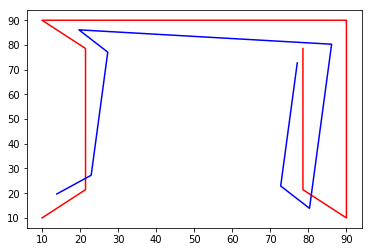


 residuals of camB relative to camA
[-3.8883 -1.4877 -5.8455 -9.6987  3.8883  9.6987  5.8455  1.4877 -9.6987
 -5.8455  1.4877  3.8883  9.6987 -3.8883 -1.4877  5.8455]
[[-3.8883 -1.4877 -5.8455 -9.6987  3.8883  9.6987  5.8455  1.4877]
 [-9.6987 -5.8455  1.4877  3.8883  9.6987 -3.8883 -1.4877  5.8455]]

 residuals of camA relative to camB
[ 3.8883  1.4877  5.8455  9.6987 -3.8883 -9.6987 -5.8455 -1.4877  9.6987
  5.8455 -1.4877 -3.8883 -9.6987  3.8883  1.4877 -5.8455]
[[ 3.8883  1.4877  5.8455  9.6987 -3.8883 -9.6987 -5.8455 -1.4877]
 [ 9.6987  5.8455 -1.4877 -3.8883 -9.6987  3.8883  1.4877 -5.8455]]


In [29]:
#
# Test the residual function to make sure it is doing the right thing.
#

# create two cameras with same intrinsic but slightly different extrinsic parameters
camA = Camera(f=200,c=np.array([[50,50]]).T,t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))
camB = Camera(f=200,c=np.array([[50,50]]).T,t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))

paramsA = np.array([0,0,0,0.5,0.5,-2.5])
paramsB = np.array([0,0,5,0.5,0.5,-3])
camA.update_extrinsics(paramsA)
camB.update_extrinsics(paramsB)

print(camA)
print(camB)

# create a test object (corners of a 3D cube) 
pts3 = np.array([[0,0,0],[0,0,1],[0,1,1],[0,1,0],[1,1,0],[1,0,0],[1,0,1],[1,1,1]]).T

# visualize the two projections
pts2A = camA.project(pts3)
pts2B = camB.project(pts3)

plt.plot(pts2A[0,:],pts2A[1,:],'r')
plt.plot(pts2B[0,:],pts2B[1,:],'b')
plt.show()

# double check that the residuals are the same as the difference in the reprojected coordinates
print("\n residuals of camB relative to camA")
print(residuals(pts3,pts2A,camB,paramsB))
print(pts2A-pts2B)

print("\n residuals of camA relative to camB")
print(residuals(pts3,pts2B,camA,paramsA))
print(pts2B-pts2A)


# 3. Camera Pose Estimation

We are now ready to estimate camera pose using optimize.  Implement a function **calibratePose** which takes as input the 3D coordinates of a calibration object, the observed 2D coordinates in the image, and an initial guess of the camera. Your function should use **scipy.optimize.leastsq** to optimize the extrinsic parameters in order to minimize the reprojection error. Since the **residuals** function takes additional arguments and **leastsq** expects a function which only takes the parameter vector as input, you should use Python's **lambda** function to wrap **residuals**, subistituting in the parameters that are fixed during the optimization. Once you have determined the optimum parameters, update the intrinsic parameters to the optimum and return the resulting camera.


## 3.1 Implementation

In [30]:
def calibratePose(pts3,pts2,cam,params_init):
    """
    Calibrate the provided camera by updating R,t so that pts3 projects
    as close as possible to pts2

    Parameters
    ----------
    pts3 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (3,N)

    pts2 : 2D numpy.array (dtype=float)
        Coordinates of N points stored in a array of shape (2,N)

    cam : Camera
        Initial estimate of camera
        
    params_init : 1D numpy.array (dtype=float)
        Initial estimate of camera extrinsic parameters ()
        params[0:2] are the rotation angles, params[2:5] are the translation

    Returns
    -------
    cam : Camera
        Refined estimate of camera with updated R,t parameters
        
    """
    
    params_up,_=scipy.optimize.leastsq(lambda params : residuals(pts3,pts2,cam,params),params_init)
    cam.update_extrinsics(params_up)
    return cam


# 3.2 Synthetic Test Example and Failure Cases

Use the code below to check that your calibrate function works. Add some code to also visualize the point locations in 3D and the location and orientation of the camera (i.e., using the 3D plotting functions from Assignment 2)

Once you are confident that your calibration function is behaving correctly, you should experiment with changing the initial parameters.  Find a set of initial parameters which yields a ***wrong*** solution (i.e. where the Final Camera is not similar to the True Camera).  In the text box below indicate what bad initialization you used and the resulting set of camera parameters after the optimization. Give a brief explanation of where this bad camera is located and what direction it is oriented in.   

**describe failure mode here**
params_init = np.array([6,5,-9,3,5,7])
Explanation: The camera is located at (2.0914 2.1912 2.9094),which is at the upper right corner of the cube and
pointed to upper right corner. In this case,the intial camera is far away from the object and doesn't look at the object, which leads the failure of the estimation.（The bad camera is shown in 'bad camera scene 3D view' and 'bad camera scene overhead view' below.）


 True Camera
Camera : 
 f=50 
 c=[[50 50]] 
 R=[[ 1.      0.      0.    ]
 [ 0.      0.9848 -0.1736]
 [ 0.      0.1736  0.9848]] 
 t = [[-1 -1 -2]]

 Initial Camera
Camera : 
 f=50 
 c=[[50 50]] 
 R=[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] 
 t = [[ 0  0 -2]]

 Final Camera
Camera : 
 f=50 
 c=[[50 50]] 
 R=[[ 0.9999  0.0077 -0.0094]
 [-0.0092  0.9849 -0.173 ]
 [ 0.0079  0.1731  0.9849]] 
 t = [[-0.9942 -0.9742 -2.0114]]


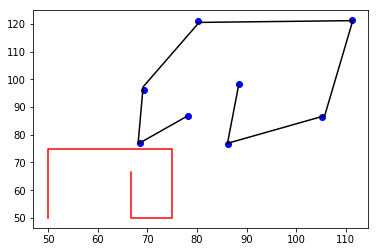


 Final Bad Camera
Camera : 
 f=50 
 c=[[50 50]] 
 R=[[-0.5643  0.561   0.6057]
 [ 0.4504 -0.4056  0.7954]
 [ 0.6919  0.7216 -0.0237]] 
 t = [[2.0914 2.1912 2.9094]]


Text(0.5, 1.0, 'bad camera scene overhead view')

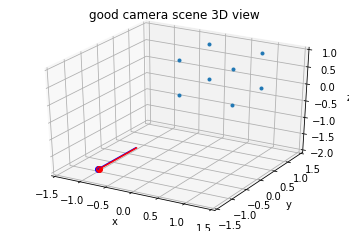

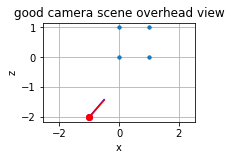

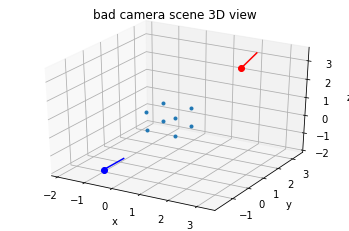

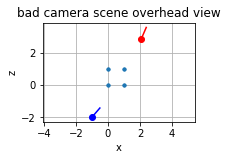

In [37]:
# 3D calibration object
pts3 = np.array([[0,0,0],[0,0,1],[0,1,1],[0,1,0],[1,1,0],[1,0,0],[1,0,1],[1,1,1]]).T

# true camera
cam_true = Camera(f=50,c=np.array([[50,50]]).T,t=np.array([[-1,-1,-2]]).T, R=makerotation(10,0,0))

print("\n True Camera")
print(cam_true)

# image of calibration object with some simulated noise in the 2D locations
pts2 = cam_true.project(pts3)
noiselevel = 0.5
pts2 = pts2 + noiselevel*np.random.randn(pts2.shape[0],pts2.shape[1])

# initial guess of camera params
cam = Camera(f=50,c=np.array([[50,50]]).T,t=np.array([[0,0,0]]).T, R=makerotation(0,0,0))
params_init = np.array([0,0,0,0,0,-2]) 
params_bad = np.array([6,5,-9,3,5,7]) # initial parameters for bad camera
cam.update_extrinsics(params_init)

print("\n Initial Camera")
print(cam)
pts2init = cam.project(pts3)

# now run calibration
cam = calibratePose(pts3,pts2,cam,params_init)

print("\n Final Camera")
print(cam)
pts2final = cam.project(pts3)

#
# Plot the true, initial and final reprojections
# The final reprojection should be on top of the true image
#
plt.plot(pts2[0,:],pts2[1,:],'bo')
plt.plot(pts2init[0,:],pts2init[1,:],'r')
plt.plot(pts2final[0,:],pts2final[1,:],'k')
plt.show()

#
# Add some additional visualiztion here to show the points in 3D and the locations and orientations
# of cam_true and cam.  You can either use a 3D plot or show multiple 2D plots (e.g. overhead
# and side views)
#

# generate coordinates of a line segment running from the center
# of the camera to 2 units in front of the camera
look_true = np.hstack((cam_true.t,cam_true.t+cam_true.R @ np.array([[0.5,0.5,0.5]]).T))
look = np.hstack((cam.t,cam.t+cam.R @ np.array([[0.5,0.5,0.5]]).T))

#visualize 3D layout of points, camera positionsc
# and the direction the camera is pointing
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
ax.plot(cam_true.t[0],cam_true.t[1],cam_true.t[2],'bo')
ax.plot(cam.t[0],cam.t[1],cam.t[2],'ro')
#The location and orientation of cam_true is shown with blue color:
ax.plot(look_true[0,:],look_true[1,:],look_true[2,:],'b') 
#The location and orientation of cam is shown with red color:
ax.plot(look[0,:],look[1,:],look[2,:],'r')
visutils.set_axes_equal_3d(ax)
visutils.label_axes(ax)
plt.title('good camera scene 3D view')

# overhead view showing points, camera
# positions, and direction camera is pointed
fig = plt.figure()
ax = fig.add_subplot(2,2,3)
ax.plot(pts3[0,:],pts3[2,:],'.')
ax.plot(cam_true.t[0],cam_true.t[2],'bo')
ax.plot(look_true[0,:],look_true[2,:],'b')
ax.plot(cam.t[0],cam.t[2],'ro')
ax.plot(look[0,:],look[2,:],'r')
plt.axis('equal')
plt.grid()
plt.xlabel('x')
plt.ylabel('z')
plt.title('good camera scene overhead view')



#For bad camera:
cam_bad = calibratePose(pts3,pts2,cam,params_bad) #run calibration on bad camera

print("\n Final Bad Camera")
print(cam_bad)
pts2final_bad = cam_bad.project(pts3)

look_bad = np.hstack((cam_bad.t,cam_bad.t+cam_bad.R @ np.array([[0.5,0.5,0.5]]).T))

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
ax.plot(cam_true.t[0],cam_true.t[1],cam_true.t[2],'bo')
ax.plot(cam_bad.t[0],cam_bad.t[1],cam_bad.t[2],'ro')
#The location and orientation of cam_true is shown with blue color:
ax.plot(look_true[0,:],look_true[1,:],look_true[2,:],'b') 
#The location and orientation of cam_bad is shown with red color:
ax.plot(look_bad[0,:],look_bad[1,:],look_bad[2,:],'r')
visutils.set_axes_equal_3d(ax)
visutils.label_axes(ax)
plt.title('bad camera scene 3D view')

fig = plt.figure()
ax = fig.add_subplot(2,2,3)
ax.plot(pts3[0,:],pts3[2,:],'.')
ax.plot(cam_true.t[0],cam_true.t[2],'bo')
ax.plot(look_true[0,:],look_true[2,:],'b')
ax.plot(cam_bad.t[0],cam_bad.t[2],'ro')
ax.plot(look_bad[0,:],look_bad[2,:],'r')
plt.axis('equal')
plt.grid()
plt.xlabel('x')
plt.ylabel('z')
plt.title('bad camera scene overhead view')

# 4. Calibration from real images

There is a provided set of calibration images (images of a planar checkerboard) along with stereo pair depicting an object. In order to calibrate the intrinsic camera parameters we will use the OpenCV library which includes functionality for automatically detecting corners of the checkerboard and estimating intrinsic parameters. To install OpenCV python libraries in your Anaconda environment. You can do this from the terminal via the command **conda install opencv** or via the Anconda Navigator gui.

I have provide a standalone script **calibrate.py** which uses OpenCV to carry out calibration of the camera intrinsic parameters for a series of checkerboard images. Read through the provided script to understand the code and modify file paths as necessary in order to compute the intrinsic camera parameters from the set of provided calibration images.


## 4.1 Implementation

Fill in the code snippet below to carry out the following steps.

1. Load in the intrinsic parameter calibration data saved by the script in *calibration.pickle*. Since our camera model assumes that the focal length is the same in the x and y axes, you can set your f to be the average of the two estimated by the script.

2. Load in the test images *Left.jpg* and *Right.jpg* and use the **cv2.findChessboardCorners** function in order to automatically get the 2D coordinates of the corners in the image.

3. Specify the true 3D coordinates of the 6x8 grid of checkerboard corners. The squares are 2.8cm x 2.8cm.

5. Use your **calibratePose** function to estimate the R,t for each camera. You will likely need to experiment with selecting the initial parameters in order to get a good solution (e.g., translate so the cameras have positive z coordinates and rotate so they are looking down on the checkerboard).


Camera : 
 f=1561.013969257042 
 c=[[1021.1465  755.8365]] 
 R=[[ 0.7928  0.5479 -0.2671]
 [ 0.6058 -0.66    0.4443]
 [ 0.0671 -0.514  -0.8552]] 
 t = [[20.2533 -0.3845 37.7861]]
Camera : 
 f=1561.013969257042 
 c=[[1021.1465  755.8365]] 
 R=[[ 0.9506  0.271  -0.1511]
 [ 0.3029 -0.7042  0.6421]
 [ 0.0676 -0.6562 -0.7516]] 
 t = [[ 17.4715 -11.9475  24.0513]]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


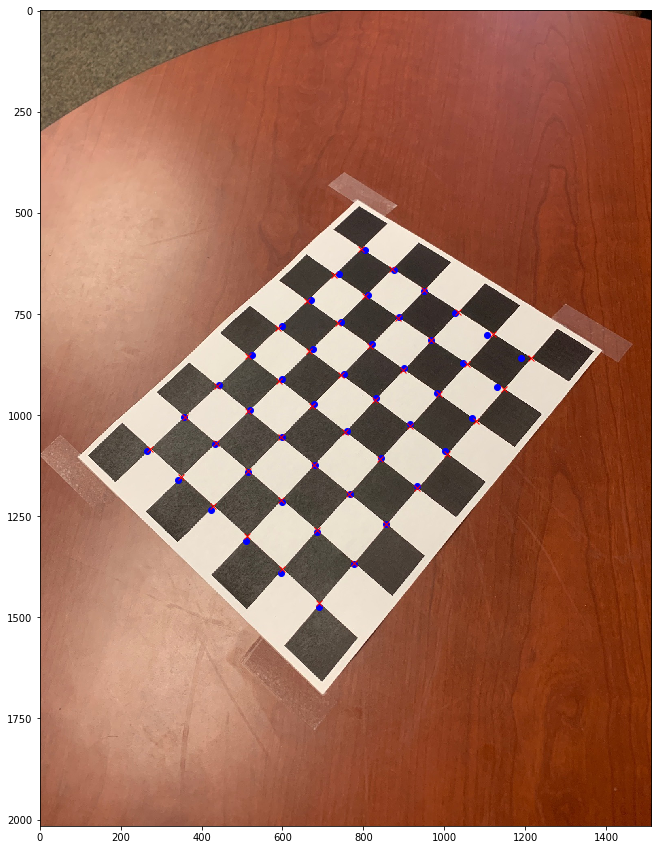

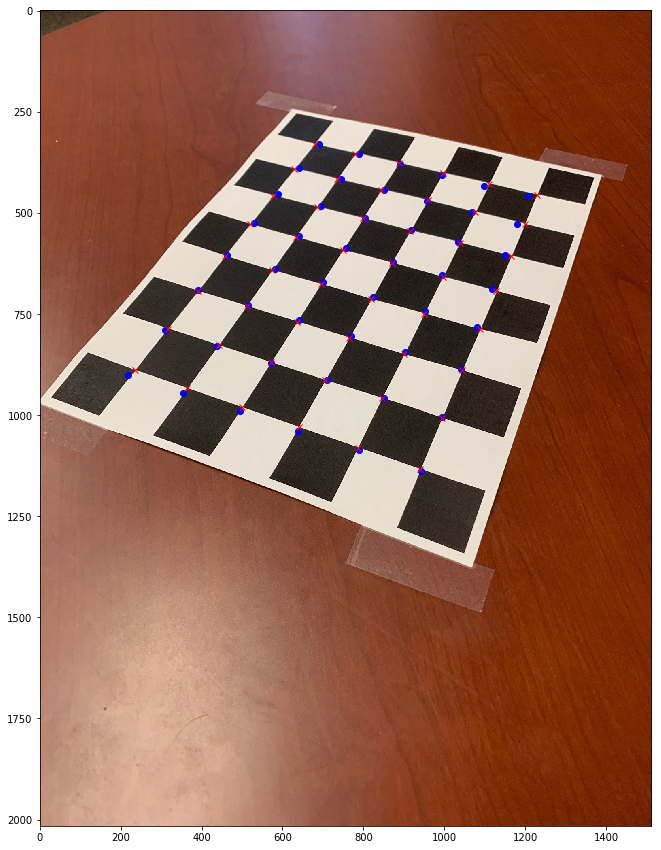

In [50]:
import cv2
import pickle

# load in the intrinsic camera parameters from 'calibration.pickle'
file = open('calibration.pickle','rb') #note: Here the data is stored with dict format
dict = pickle.load(file)
f=(dict['fx']+dict['fy'])/2
c=np.array([[dict['cx']],[dict['cy']]])
t=np.array([[0,0,0]]).T
R=makerotation(0,0,0)

# create Camera objects representing the left and right cameras
# use the known intrinsic parameters you loaded in.
camL = Camera(f,c,R,t)
camR = Camera(f,c,R,t)

# load in the left and right images and find the coordinates of
# the chessboard corners using OpenCV
imgL = plt.imread('calib1/Left.jpg')
ret, cornersL = cv2.findChessboardCorners(imgL, (8,6), None)
pts2L = cornersL.squeeze().T

imgR = plt.imread('calib1/Right.jpg')
ret, cornersR = cv2.findChessboardCorners(imgR, (8,6), None)
pts2R = cornersR.squeeze().T

# generate the known 3D point coordinates of points on the checkerboard in cm
pts3 = np.zeros((3,6*8))
yy,xx = np.meshgrid(np.arange(8),np.arange(6))
pts3[0,:] = 2.8*xx.reshape(1,-1)
pts3[1,:] = 2.8*yy.reshape(1,-1)


# Now use your calibratePose function to get the extrinsic parameters
# for the two images. You may need to experiment with the initialization
# in order to get a good result

#set tz so the cameras have positive z coordinates
#set ry so that they are looking down on the checkboard
params_init_L=np.array([0,-1,0,0,0,-1]) 
params_init_R=np.array([0,1,0,0,0,-1]) 

camL = calibratePose(pts3,pts2L,camL,params_init_L)
camR = calibratePose(pts3,pts2R,camR,params_init_R)

print(camL)
print(camR)

# As a final test, triangulate the corners of the checkerboard to get back there 3D locations
def triangulate(pts2L,camL,pts2R,camR):
    assert(pts2L.shape[0]==pts2R.shape[0])
    assert(pts2L.shape[0]==2)
    
    #convert from pixel coordinates into image coordinates
    #subtract c and add a ones array to get the homogeneous coord
    ones = np.ones((1,pts2L.shape[1]))
    qL = np.vstack(((pts2L-camL.c)/camL.f,ones))
    qR = np.vstack(((pts2R-camR.c)/camR.f,ones))
    
 
    #use np.linalg.lstsq to get the least-squares estimate of the z coordinates
    #use the equation of class notes
    pts3_L = np.zeros(shape=(3,pts2R.shape[1]))
    pts3_R = np.zeros(shape=(3,pts2R.shape[1]))
    for i in range(pts2R.shape[1]):
        a = camL.R@(qL[:,i].reshape(3,1))
        b = -camR.R@(qR[:,i].reshape(3,1))
        Zl,Zr = np.linalg.lstsq(np.hstack((a,b)),camR.t-camL.t)[0]      
        #use z back to relative coord caculation to get pts3
        pts3_L[:,i] = (camL.R@(Zl*qL[:,i]).reshape(3,1)+camL.t).reshape(3) #pts3 caculated by left camera
        pts3_R[:,i] = (camR.R@(Zr*qR[:,i]).reshape(3,1)+camR.t).reshape(3) #pts3 caculated by right camera
        
    pts3 = (pts3_L + pts3_R)/2 #the final pts3 should be the average of two values caculated on last step
    
    assert(pts3.shape[1]==pts2R.shape[1])
    assert(pts3.shape[0]==3)
    return pts3

pts3r = triangulate(pts2L,camL,pts2R,camR)

# Display the reprojected points overlayed on the images to make 
# sure they line up
plt.rcParams['figure.figsize']=[15,15]
pts2Lp = camL.project(pts3)
plt.imshow(imgL)
plt.plot(pts2Lp[0,:],pts2Lp[1,:],'bo')
plt.plot(pts2L[0,:],pts2L[1,:],'rx')
plt.show()

pts2Rp = camR.project(pts3)
plt.imshow(imgR)
plt.plot(pts2Rp[0,:],pts2Rp[1,:],'bo')
plt.plot(pts2R[0,:],pts2R[1,:],'rx')
plt.show()


The code below provides a visualization of the estimate camera positions relative to the checkerboard.

Text(0, 0.5, 'y')

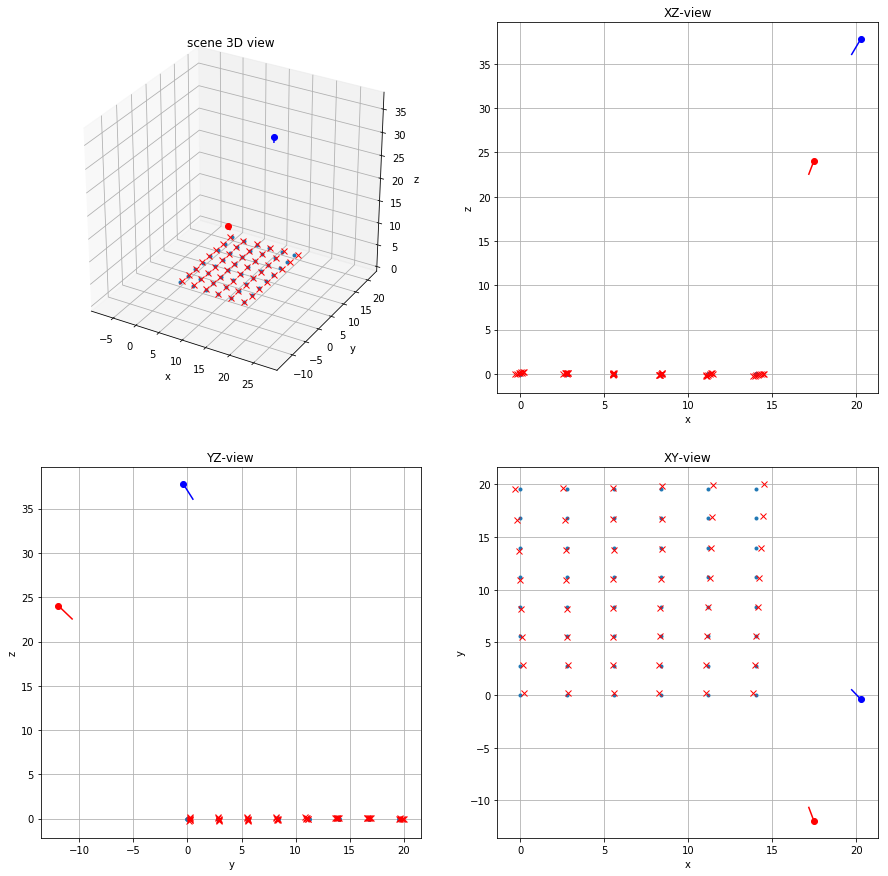

In [51]:
# generate coordinates of a line segment running from the center
# of the camera to 3 units in front of the camera
lookL = np.hstack((camL.t,camL.t+camL.R @ np.array([[0,0,2]]).T))
lookR = np.hstack((camR.t,camR.t+camR.R @ np.array([[0,0,2]]).T))

# visualize the left and right image overlaid
fig = plt.figure()
ax = fig.add_subplot(2,2,1,projection='3d')
ax.plot(pts3[0,:],pts3[1,:],pts3[2,:],'.')
ax.plot(pts3r[0,:],pts3r[1,:],pts3r[2,:],'rx')
ax.plot(camR.t[0],camR.t[1],camR.t[2],'ro')
ax.plot(camL.t[0],camL.t[1],camL.t[2],'bo')
ax.plot(lookL[0,:],lookL[1,:],lookL[2,:],'b')
ax.plot(lookR[0,:],lookR[1,:],lookR[2,:],'r')
visutils.set_axes_equal_3d(ax)
visutils.label_axes(ax)
plt.title('scene 3D view')

ax = fig.add_subplot(2,2,2)
ax.plot(pts3[0,:],pts3[2,:],'.')
ax.plot(pts3r[0,:],pts3r[2,:],'rx')
ax.plot(camR.t[0],camR.t[2],'ro')
ax.plot(camL.t[0],camL.t[2],'bo')
ax.plot(lookL[0,:],lookL[2,:],'b')
ax.plot(lookR[0,:],lookR[2,:],'r')
plt.title('XZ-view')
plt.grid()
plt.xlabel('x')
plt.ylabel('z')

ax = fig.add_subplot(2,2,3)
ax.plot(pts3[1,:],pts3[2,:],'.')
ax.plot(pts3r[1,:],pts3r[2,:],'rx')
ax.plot(camR.t[1],camR.t[2],'ro')
ax.plot(camL.t[1],camL.t[2],'bo')
ax.plot(lookL[1,:],lookL[2,:],'b')
ax.plot(lookR[1,:],lookR[2,:],'r')
plt.title('YZ-view')
plt.grid()
plt.xlabel('y')
plt.ylabel('z')

ax = fig.add_subplot(2,2,4)
ax.plot(pts3[0,:],pts3[1,:],'.')
ax.plot(pts3r[0,:],pts3r[1,:],'rx')
ax.plot(camR.t[0],camR.t[1],'ro')
ax.plot(camL.t[0],camL.t[1],'bo')
ax.plot(lookL[0,:],lookL[1,:],'b')
ax.plot(lookR[0,:],lookR[1,:],'r')
plt.title('XY-view')
plt.grid()
plt.xlabel('x')
plt.ylabel('y')

***
## 4.2 Recovered Pose
Using the provided calibration images, what are the recovered parameters for the left and right cameras?  How far apart are the camera centers in centimeters (i.e. what is the baseline) ?

In [79]:
#the recovered parameters for the left and right cameras:
print('(1)a.The recovered parameters for the left',camL)
print('b.The recovered parameters for the right',camR)

#the baseline:
print('(2)The baseline length:',np.sqrt(np.sum(np.power((camL.t-camR.t),2),axis=0)),'cm')

(1)a.The recovered parameters for the left Camera : 
 f=1561.013969257042 
 c=[[1021.1465  755.8365]] 
 R=[[ 0.7928  0.5479 -0.2671]
 [ 0.6058 -0.66    0.4443]
 [ 0.0671 -0.514  -0.8552]] 
 t = [[20.2533 -0.3845 37.7861]]
b.The recovered parameters for the right Camera : 
 f=1561.013969257042 
 c=[[1021.1465  755.8365]] 
 R=[[ 0.9506  0.271  -0.1511]
 [ 0.3029 -0.7042  0.6421]
 [ 0.0676 -0.6562 -0.7516]] 
 t = [[ 17.4715 -11.9475  24.0513]]
(2)The baseline length: [18.1682] cm


***
## 4.3 Reconstruction Accuracy

Using the estimated camL and camR and the 2D point locations, triangulate to get 3D locations. What is the average error (in cm) for your recovered 3D locations of the grid corner points relative to their true coordinates?  Where might this error be coming from?

In [80]:
#average error:
print('The average error is',np.mean(np.sqrt(np.sum(np.power((pts3-pts3r),2),axis=0))),'cm')

The average error is 0.2375570882775222 cm


This error might comes from：
1. The intial parameter is not ideal;
2. The scipy.optimize.leastsq is not able to get 100% accuracy without any error;
3. The focal length of camera got from average of fx,fy is not accurate;
4. The picture dateset we got for opencv training is not sufficiently enough.

***
## 4.4 Focal Length

The checkerboard photos were taken with an iPhone Xs. Teardowns of this device reveal that the sensor is 5.6mm wide. Based on this and your recovered value for f, what was the focal length in millimeters? Explain how you computed this. Is the result you get a reasonable match to the published focal length of of 4.25mm?

Dividing the image dimension in pixels by the sensor dimension in mm to get a conversion ratio and multiply f in pixels:
FocalLength=f∗(sensorwidth/imagewidth)

In [87]:
print('The FocalLength is',f*(5.6/imgL.shape[0]),'mm')

The FocalLength is 4.336149914602894 mm
